# Hypergraph information

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations

sys.path.append("../src/")

import xgi
from reducibility_hg import *

from statannotations.Annotator import Annotator

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir = f"{results_dir}synthetic/"

In [3]:
def optimization_rescaled(
    H, tau, rescaling_factors, rescale_per_node=False, sparse=False
):

    orders = np.array(xgi.unique_edge_sizes(H)) - 1
    weights = np.ones(len(orders))
    L_multi = xgi.multiorder_laplacian(
        H, orders, weights, rescale_per_node=rescale_per_node, sparse=sparse
    )

    rho_all = density(L_multi, tau, sparse=sparse)

    D = []  # Learning error
    lZ = []  # Penalization term for model complexity

    for l in range(len(orders)):
        L_l = xgi.multiorder_laplacian(
            H,
            orders[0 : l + 1],
            weights[0 : l + 1],
            rescale_per_node=rescale_per_node,
            sparse=sparse,
        )
        rho_l = density(L_l, tau * rescaling_factors[l], sparse=sparse)
        d = KL(rho_all, rho_l, sparse=sparse)
        z = penalization(L_l, tau * rescaling_factors[l], sparse=sparse)

        D.append(d)
        lZ.append(z)

    lZ = np.array(lZ)
    D = np.array(D)

    return D, lZ


def pad_arr_list(arr_list):
    max_shape = max([a.shape[0] for a in arr_list])

    # Pad the shorter arrays with zeros
    padded_arr_list = [
        np.pad(a, (0, max_shape - a.shape[0]), mode="constant", constant_values=None)
        for a in arr_list
    ]
    return padded_arr_list

# Density - $\tau$ analysis, rescaling $\tau$

In [4]:
rf_1 = 1
rf_2 = rf_1 + 2
rf_3 = rf_2 + 3
rf_4 = rf_3 + 4
inverse_rescaling_factors = np.array([1 / rf_1, 1 / rf_2, 1 / rf_3, 1 / rf_4]) * rf_4

### density = 5

In [21]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p == 0:
            Hs_i.append(H0)
        else:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
            Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [22]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

labels = [f"{i}" for i in np.linspace(0.25, 1, 4)]

In [23]:
for i, s in enumerate(np.linspace(0.25, 1, 4)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:9.582e-01 t=5.252e-02
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.846e-08 t=5.895e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:7.316e-07 t=5.121e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.999e-06 t=4.903e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:7.466e-01 t=3.236e-01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.277e-10 t=-6.794e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:2.202e-08 t=5.833e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=-8.151e+15
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=2.095e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=-3.157e+14


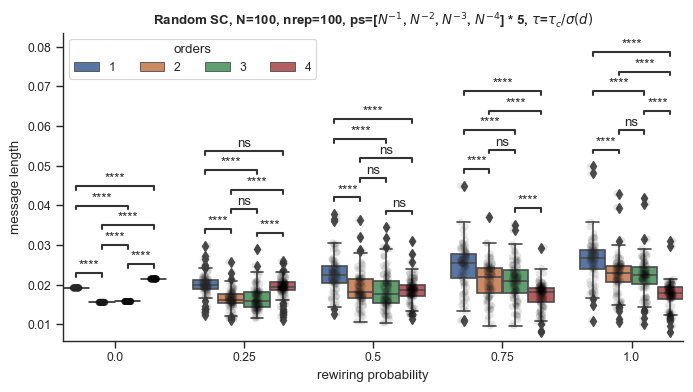

In [24]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_0_25_50_75_100_s_5_char_tau_1_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [34]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [36]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 10 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [37]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:4.878e-35 t=1.666e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:5.024e-37 t=1.776e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.454e-10 t=6.625e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:2.572e-09 t=6.265e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:4.709e-07 t=5.220e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:4.533e-35 t=1.665e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.013e-12 t=7.638e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=7.213e+15
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=5.270e+15
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=1.326e+15
0.2

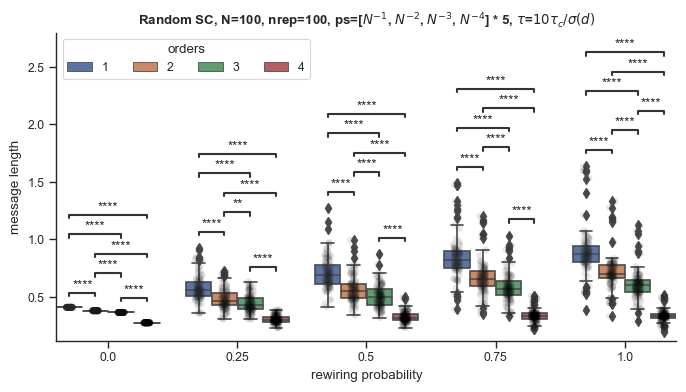

In [38]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$10\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_0_25_50_75_100_s_5_char_tau_10_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [39]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [41]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 30 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [42]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:9.349e-34 t=1.567e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.567e-34 t=1.614e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:8.534e-06 t=4.574e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:2.488e-04 t=3.732e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:2.752e-25 t=1.280e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:2.514e-39 t=1.764e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.962e-08 t=5.874e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=1.941e+16
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=1.225e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=1.734e+16
0.2

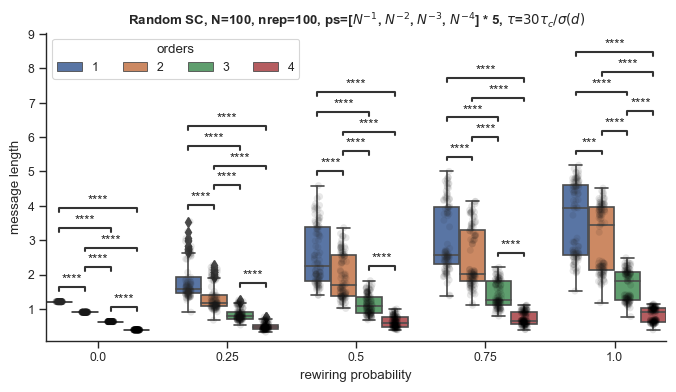

In [43]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$30\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_30_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [44]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([5] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [46]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 100 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [47]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:5.115e-43 t=2.109e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.874e-28 t=1.524e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.696e-03 t=3.193e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.515e-02 t=2.453e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:7.404e-18 t=1.042e+01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:2.206e-68 t=2.708e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.005e-12 t=7.863e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=inf
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=2.253e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=inf
0.25_1 vs. 0.25

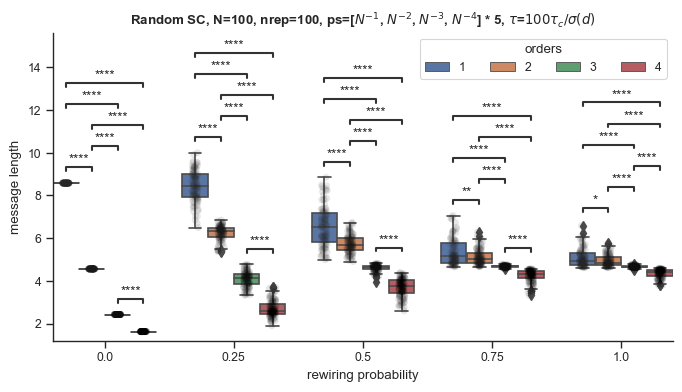

In [48]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 5, $\tau$=$100\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_5_char_tau_100_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

### density = 50

In [49]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [50]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [51]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:4.830e-01 t=-7.028e-01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:3.500e-05 t=4.237e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.274e-11 t=7.200e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:3.662e-14 t=8.179e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:4.851e-01 t=6.995e-01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.531e-18 t=-9.607e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:9.859e-15 t=8.393e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=-3.411e+16
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=7.102e+15
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=3.466e+15


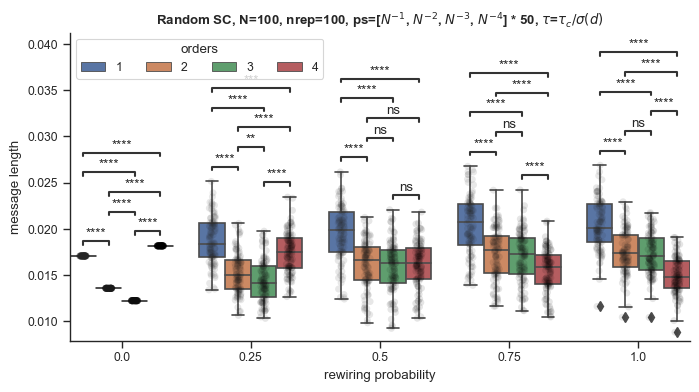

In [52]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_1_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [55]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [56]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 10 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [57]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:7.047e-37 t=1.652e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.324e-40 t=1.784e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:8.554e-01 t=1.824e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:6.745e-01 t=-4.206e-01
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:5.237e-03 t=2.824e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:7.352e-45 t=2.036e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.120e-01 t=1.596e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=7.706e+15
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=3.131e+15
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=7.062e+15
0.

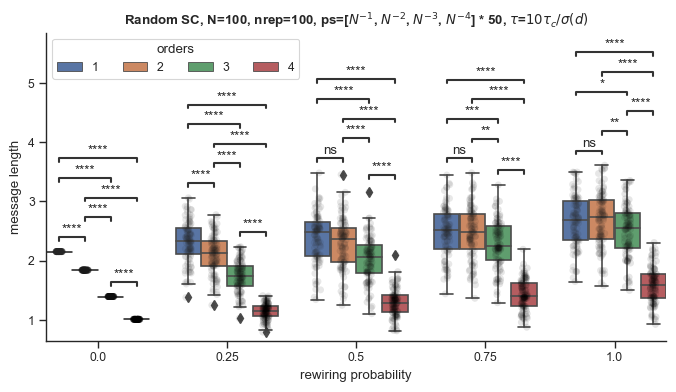

In [58]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$10\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_10_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [60]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [61]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 30 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [62]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:8.147e-35 t=1.848e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:9.020e-29 t=1.522e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:5.698e-01 t=5.694e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:8.575e-01 t=1.798e-01
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:3.534e-07 t=5.318e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:7.234e-51 t=2.884e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:3.276e-02 t=2.151e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=1.093e+16
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=1.579e+15
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=2.481e+15
0.2

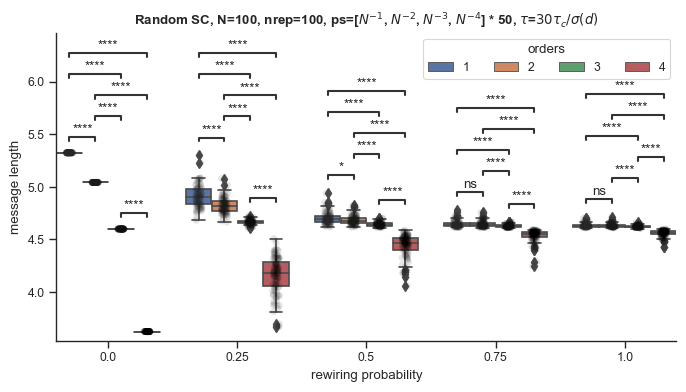

In [63]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$30\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_30_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [65]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([50] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [66]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 100 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [67]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.101e-02 t=2.574e+00
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:4.636e-03 t=2.887e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.000e+00 t=-7.542e-06
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:9.998e-01 t=-1.968e-04
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:9.996e-01 t=4.850e-04
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.678e-14 t=8.520e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.000e+00 t=4.716e-05
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=3.532e+12
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=inf
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=2.626e+12
0.25_1 

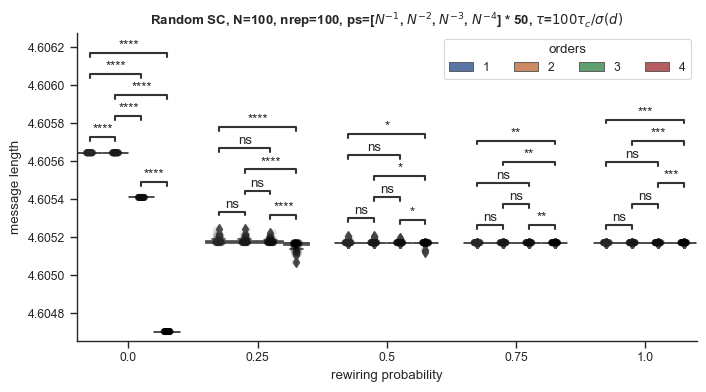

In [69]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 50, $\tau$=$100\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_50_char_tau_100_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

## density = 100

In [7]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [8]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [9]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:5.131e-01 t=-6.552e-01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:2.398e-09 t=6.263e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:4.779e-36 t=1.582e+01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.449e-39 t=1.703e+01
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:3.247e-01 t=9.874e-01
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:1.920e-29 t=-1.341e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.364e-37 t=1.636e+01
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=-1.018e+16
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=1.190e+16
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=2.099e+15


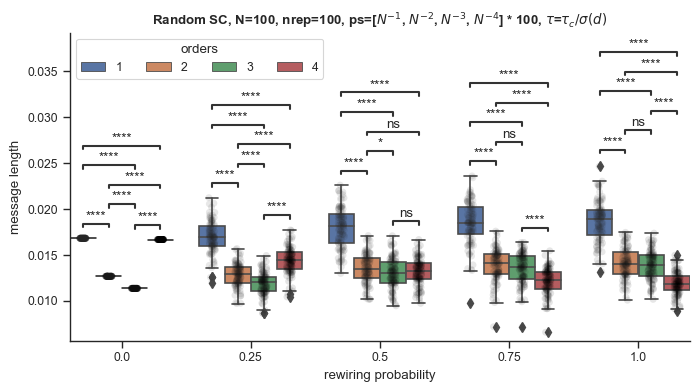

In [10]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_1_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [12]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [13]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 10 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [14]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:5.049e-33 t=1.462e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:6.317e-30 t=1.354e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:3.103e-01 t=-1.017e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:7.984e-02 t=-1.761e+00
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:6.012e-02 t=1.891e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.106e-48 t=2.033e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:4.140e-01 t=8.186e-01
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:8.166e-06 t=4.581e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:9.390e-15 t=8.397e+00
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:1.263e-04 t=3.911e+

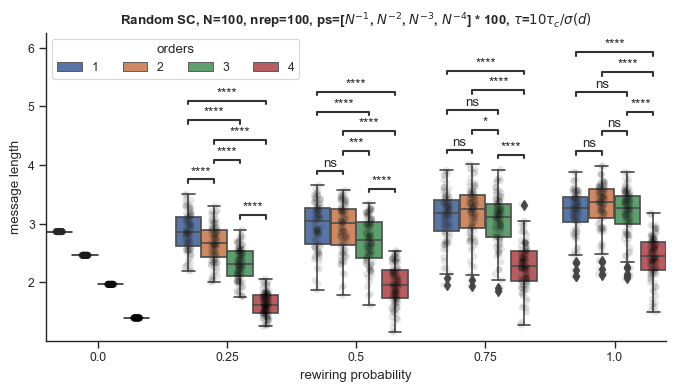

In [15]:
fix, ax = plt.subplots(figsize=(8, 4))

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$10\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0.25, 1, 4):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_10_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [6]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [7]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 30 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [8]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:3.639e-32 t=1.644e+01
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:1.296e-24 t=1.319e+01
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:6.910e-01 t=-3.982e-01
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:5.873e-01 t=-5.436e-01
1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:4.138e-02 t=2.057e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:8.913e-28 t=1.466e+01
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:4.016e-01 t=8.407e-01
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=8.227e+13
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:0.000e+00 t=5.055e+13
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=3.271e+13
0

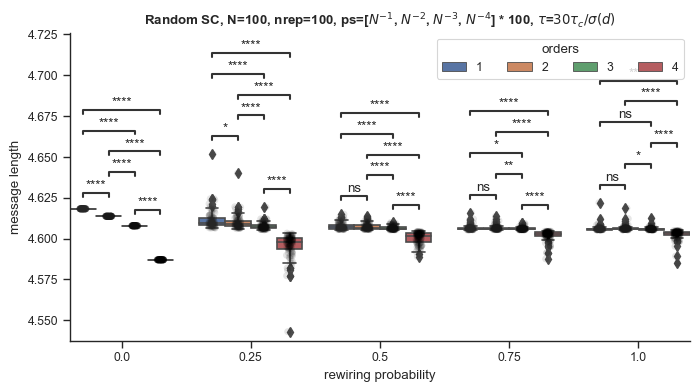

In [9]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$30\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_30_rescaled_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [10]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])
densities = np.array([100] * 4)

H0 = xgi.random_simplicial_complex(N, ps=densities * ps)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

Hs = dict()
for p in np.linspace(0, 1, 5):
    Hs_i = []
    for rep in range(100):
        if (rep + 1) % 100 == 0:
            print(rep + 1)
        if p != 0:
            H = shuffle_hyperedges(S=H0, order=1, p=p)
            H = shuffle_hyperedges(S=H, order=2, p=p)
            H = shuffle_hyperedges(S=H, order=3, p=p)
            H = shuffle_hyperedges(S=H, order=4, p=p)
        else:
            H = xgi.Hypergraph(H0.edges.members(dtype=dict))
        Hs_i.append(H)
    Hs[p] = Hs_i

100
100
100
100
100


In [11]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for p, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H in Hs_i:
        orders = np.array(xgi.unique_edge_sizes(H)) - 1
        weights = np.ones(len(orders))
        tau_c = find_charact_tau(H, orders, weights, rescale_per_node=False)
        Ds_H, lZs_H = optimization_rescaled(
            H, 100 * tau_c, inverse_rescaling_factors, rescale_per_node=False
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[p] = info_losses_i
    complexities[p] = complexities_i
    orders_arr[p] = orders_arr_i
    message_lengths[p] = message_lengths_i

In [12]:
for i, s in enumerate(np.linspace(0, 1, 5)):
    message_lengths[s] = pad_arr_list(message_lengths[s])

df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()

for i, d in enumerate(orders):
    df[d] = df[0].apply(lambda x: x[i])

df = df[orders]

dff = df.reset_index(names=["rewiring probability", "rep"]).melt(
    id_vars=["rewiring probability", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message length",
)

c:\Users\luca9\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
c:\Users\luca9\anaconda3\lib\site-packages\statannotations\stats\StatTest.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, pval = self._func(group_data1, group_data2, *self.args,


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.5_3 vs. 0.5_4: Welch's t-test independent samples, P_val:1.027e-03 t=3.356e+00
0.75_3 vs. 0.75_4: Welch's t-test independent samples, P_val:8.401e-03 t=2.675e+00
0.75_1 vs. 0.75_2: Welch's t-test independent samples, P_val:1.000e+00 t=0.000e+00
1.0_1 vs. 1.0_2: Welch's t-test independent samples, P_val:1.000e+00 t=-1.836e-05


1.0_2 vs. 1.0_3: Welch's t-test independent samples, P_val:1.000e+00 t=0.000e+00
0.25_3 vs. 0.25_4: Welch's t-test independent samples, P_val:3.351e-05 t=4.324e+00
0.5_1 vs. 0.5_2: Welch's t-test independent samples, P_val:1.000e+00 t=0.000e+00
0.0_3 vs. 0.0_4: Welch's t-test independent samples, P_val:0.000e+00 t=1.476e+10
0.0_1 vs. 0.0_2: Welch's t-test independent samples, P_val:5.887e-150 t=7.739e+01
0.0_2 vs. 0.0_3: Welch's t-test independent samples, P_val:0.000e+00 t=3.134e+06
0.25_1 vs. 0.25_2: Welch's t-test independent samples, P_val:1.000e+00 t=0.000e+00
0.25_2 vs. 0.25_3: Welch's t-test independent samples, P_val:9.990e-01 t=1.252e-03
0.5_2 vs. 0.5_3: Welch's t-test independent samples, P_val:9.999e-01 t=1.496e-04
0.75_2 vs. 0.75_3: Welch's t-test independent samples, P_val:9.993e-01 t=-8.370e-04
1.0_3 vs. 1.0_4: Welch's t-test independent samples, P_val:1.649e-01 t=1.395e+00
1.0_1 vs. 1.0_3: Welch's t-test independent samples, P_val:1.000e+00 t=-1.836e-05
0.5_2 vs. 0.5_4: 

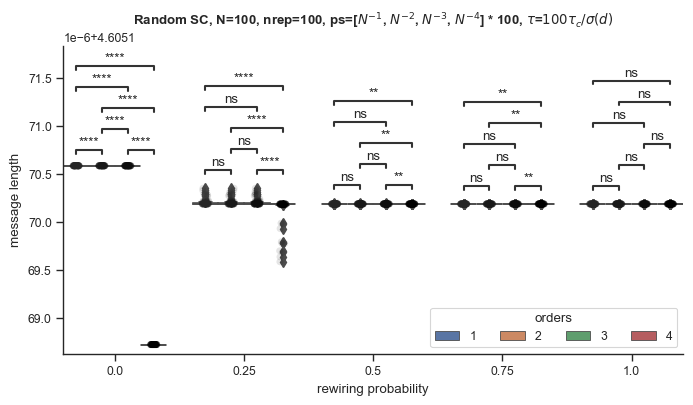

In [13]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(8, 4))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(
    data=dff, hue="order", y="message length", x="rewiring probability", ax=ax
)  # , **box_params)
plt.legend(title="orders", ncols=4)

sb.stripplot(
    data=dff,
    hue="order",
    y="message length",
    x="rewiring probability",
    ax=ax,
    color="black",
    dodge=True,
    alpha=0.1,
    legend=False,
)

sb.despine()
ax.set_title(
    rf"Random SC, N={N}, nrep={100}, ps=[$N^{{-1}}$, $N^{{-2}}$, $N^{{-3}}$, $N^{{-4}}$] * 100, $\tau$=$100\tau_c/\sigma(d)$",
    weight="bold",
)


pairs = []
for p in np.linspace(0, 1, 5):
    pairs.append([(p, 3), (p, 4)])
    pairs.append([(p, 1), (p, 2)])
    pairs.append([(p, 1), (p, 3)])
    pairs.append([(p, 1), (p, 4)])
    pairs.append([(p, 2), (p, 3)])
    pairs.append([(p, 2), (p, 4)])

annotator = Annotator(
    ax, pairs, data=dff, x="rewiring probability", y="message length", hue="order"
)
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

# fig_name = f"message_length_RHG_N{N}_pwiring_{sparsity_scales}_nreps_{n_rep}_boxplot"
fig_name = (
    f"message_length_RSC_N_100_p_25_50_75_100_s_100_char_tau_100_rescaled_boxplot"
)
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")